In [132]:
import torch
import time
import matplotlib.pyplot as plt
import non_local_boxes

# Sugar coating for reloading
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Basic Gradient Descent

## 1.1. Maximization under constraints

As we maximize under constraints, we need the orthogonal projection onto the unit hypercube $[0,1]^{32}$:

In [ ]:
def projected_wiring_basic(W):  # W is a 32xn tensor
    W = torch.maximum(W, torch.zeros_like(W))  # it outputs the element-wise maximum
    W = torch.minimum(W, torch.ones_like(W))   # similarly for minimum
    return W

In [ ]:
def projected_wiring(W):  # W is a 32xn tensor
    W = torch.maximum(W, torch.zeros_like(W))  # it outputs the element-wise maximum
    W = torch.minimum(W, torch.ones_like(W))   # similarly for minimum

    # Then we verify the 4 equalities of (5)
    for alpha in range(non_local_boxes.evaluate.nb_columns):
        #1
        if abs(W[0, alpha] - W[1, alpha]) <= abs(W[8, alpha] - W[9, alpha]):
            W[0, alpha] = (W[0, alpha]+W[1, alpha])/2
            W[1, alpha] = W[0, alpha]
        else:
            W[8, alpha] = (W[8, alpha]+W[9, alpha])/2
            W[9, alpha] = W[8, alpha]
            
        #2
        if abs(W[2, alpha] - W[3, alpha]) <= abs(W[10, alpha] - W[11, alpha]):
            W[2, alpha] = (W[2, alpha]+W[3, alpha])/2
            W[3, alpha] = W[2, alpha]
        else:
            W[10, alpha] = (W[10, alpha]+W[11, alpha])/2
            W[11, alpha] = W[10, alpha]
            
        #3
        if abs(W[4, alpha] - W[5, alpha]) <= abs(W[12, alpha] - W[13, alpha]):
            W[4, alpha] = (W[4, alpha]+W[5, alpha])/2
            W[5, alpha] = W[4, alpha]
        else:
            W[12, alpha] = (W[12, alpha]+W[13, alpha])/2
            W[13, alpha] = W[12, alpha]
                
        #4
        if abs(W[6, alpha] - W[7, alpha]) <= abs(W[14, alpha] - W[15, alpha]):
            W[6, alpha] = (W[6, alpha]+W[7, alpha])/2
            W[7, alpha] = W[6, alpha]
        else:
            W[14, alpha] = (W[14, alpha]+W[15, alpha])/2
            W[15, alpha] = W[14, alpha]

    return W

In [ ]:
W = non_local_boxes.utils.random_wiring(3).detach()
torch.abs(W[0,:]-W[1,:]) <= torch.ones(3)/2

In [ ]:
W = non_local_boxes.utils.W_BS09(non_local_boxes.evaluate.nb_columns).detach()
P = non_local_boxes.utils.SR
Q = non_local_boxes.utils.PR
float(non_local_boxes.evaluate.phi_flat(W, P, Q)[0])

## 1.2. Gradient Descent

In [ ]:
def gradient_descent(starting_W, P, Q, learning_rate = 2, nb_steps = 20):
    external_grad = torch.ones(non_local_boxes.evaluate.nb_columns)
    W = starting_W
    for i in range(nb_steps):
        non_local_boxes.evaluate.phi_flat(W, P, Q).backward(gradient=external_grad)
        W = projected_wiring(W + learning_rate*W.grad).detach()  # create a brand new tensor, forgeting the previous gradient
        W.requires_grad=True
    return W

In [ ]:
# Initialization
starting_W = non_local_boxes.utils.random_wiring(non_local_boxes.evaluate.nb_columns)
P = non_local_boxes.utils.SR
Q = non_local_boxes.utils.PR
learning_rate = 2
nb_steps = 20


# Gradient Descent
print("(Iterating...)")
tic = time.time()
gradient_descent(starting_W, P, Q, learning_rate, nb_steps)
toc = time.time()


# Result
list = non_local_boxes.evaluate.phi_flat(W, P, Q).detach().numpy()
print("")
print("Number of tested wirings: ", len(list))
print("--> Min:    ", min(list))
print("--> Av.:    ", sum(list)/len(list))
index, value = max(enumerate(list), key=lambda x: x[1])
best_wiring = W[:,index].detach().numpy()
print("--> Max:    ", value)
print("Duration: ", (toc-tic)*1e0, "s")
print("")
print("-----")
print("The best wiring is:\n", best_wiring)
print("-----")
non_local_boxes.utils.wiring_to_functions(best_wiring)

In [ ]:
[0.24272715, 0.12160056, 0.9498826 , 0.02322189, 0.39412087,
       0.39412087, 0.83709   , 0.52627677, 0.        , 0.        ,
       1.        , 1.        , 0.        , 0.        , 1.        ,
       1.        , 1.        , 0.        , 1.        , 0.        ,
       1.        , 0.        , 1.        , 0.        , 1.        ,
       0.        , 1.        , 0.        , 1.        , 0.        ,
       1.        , 0.        ]

In [ ]:
W = torch.t(torch.tensor([[0., 0., 1. , 0., 0.,
       0., 1.   , 0.5 , 0.        , 0.        ,
       1.        , 1.        , 0.        , 0.        , 1.        ,
       1.        , 1.        , 0.        , 1.        , 0.        ,
       1.        , 0.        , 1.        , 0.        , 1.        ,
       0.        , 1.        , 0.        , 1.        , 0.        ,
       1.        , 0.        ]]))

P = non_local_boxes.utils.SR
Q = non_local_boxes.utils.PR
float(non_local_boxes.evaluate.phi_flat(W, P, Q)[0])

## 1.3 Test in the triangle PR-P0-P1

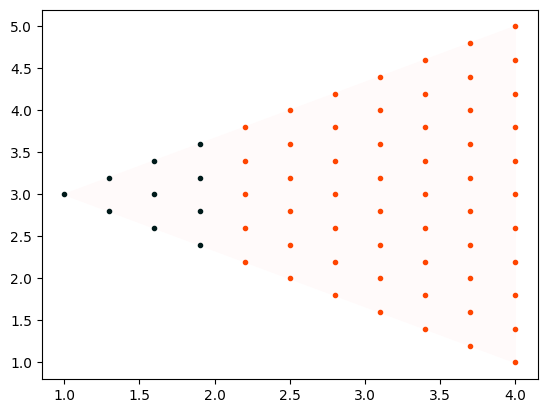

In [145]:
X = torch.tensor([[1,3], [4,1], [4, 5]]).numpy()

triangle = plt.Polygon(X[:3,:], color="snow")
plt.gca().add_patch(triangle)

number_steps = 10
threshold = (3 + float(torch.sqrt(torch.tensor(6))))/6
number_products = 10

PR = non_local_boxes.utils.PR
P_0 = non_local_boxes.utils.P_0
P_1 = non_local_boxes.utils.P_1
W_BS09 = non_local_boxes.utils.W_BS09(non_local_boxes.evaluate.nb_columns).detach()
W_random = non_local_boxes.utils.random_wiring(non_local_boxes.evaluate.nb_columns)

for i in range(number_steps+1):
    for j in range(number_steps-i+1):
        alpha = i/number_steps
        beta = j/number_steps
        P = alpha*PR + beta*P_0 + (1-alpha-beta)*P_1   # P is a 4x4 matrix
        color_point = "orangered"

        # Given a box P, we look for the W maximizing P x_W P
        W = gradient_descent(W_random, P, P, learning_rate=2, nb_steps=20)
        list = non_local_boxes.evaluate.phi_flat(W, P, P).detach().numpy()
        index, value = max(enumerate(list), key=lambda x: x[1])
        best_wiring = W[:,index].detach()
        print(value)
        
        Q=torch.clone(P)
        Q=non_local_boxes.utils.matrix_to_tensor(Q)  # Q is a 2x2x2x2 tensor 
        for k in range(number_products+1):
            if non_local_boxes.evaluate.h_flat(Q)[0] > threshold:
                color_point = (0, 0.1*(1-k/number_products)+1*(k/number_products), 0.1*(1-k/number_products)+1*(k/number_products))
                break
            #Q2=Q.copy()
            Q=non_local_boxes.evaluate.R(W, non_local_boxes.utils.tensor_to_matrix(Q), P)[:,:,:,:,0]

        plt.plot(X[0,0]*alpha + X[1,0]*beta + X[2,0]*(1-alpha-beta), X[0,1]*alpha + X[1,1]*beta + X[2,1]*(1-alpha-beta), 'o', markersize=3, color=color_point)
                

plt.show()